In [1]:
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import seaborn.objects as so

from sklearn import linear_model    # Herramientas de modelos lineales
from sklearn.metrics import mean_squared_error, r2_score    # Medidas de desempeño
from sklearn.preprocessing import PolynomialFeatures    # Herramientas de polinomios

from formulaic import Formula

/home/matias/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# Si necesitan instalar algún paquete
#pip install gapminder
#pip install formulaic

## Introducción: sistemas de ecuaciones lineales

Sabemos que un fonde de inversión invirtió en acciones de YPF, Santander y Nvidia (y solo en estas acciones) pero no sabemos cuántas acciones compró de cada una. ¿Cómo podemos averiguarlo? 

Suponemos que tenemos disponible:
1. La valorización del fondo al final de cada día.
2. El valor la acción de cada empresa al cierre de cada día.

In [3]:
# Cargamos los datos
dataDict = {'total': [170262,169929.5,171064,169637.35,164625.45], 
        'YPF': [20935, 21030, 20770, 20950, 20750], 
        'Santander': [20100, 20500, 21700, 21000, 20316], 
        'Nvidia': [37100, 36255, 36000, 35645.5, 33878.5]}
data = pd.DataFrame.from_dict(dataDict)
data

,total,YPF,Santander,Nvidia
0,170262.00,20935,20100,37100.0
1,169929.50,21030,20500,36255.0
2,171064.00,20770,21700,36000.0
3,169637.35,20950,21000,35645.5
4,164625.45,20750,20316,33878.5


Nos quedamos con las primeras tres filas y resolvemos el sistema lineal:
$$total = c_1 \cdot YPF + c_2 \cdot Santander + c_3 \cdot Nvidia$$


In [4]:
data_3rows = data[[True, True, True, False, False]]
data_3rows

,total,YPF,Santander,Nvidia
0,170262.0,20935,20100,37100.0
1,169929.5,21030,20500,36255.0
2,171064.0,20770,21700,36000.0


In [5]:
X_3rows = data_3rows[["YPF", "Santander", "Nvidia"]]
y_3rows = data_3rows["total"]
display(X_3rows)
display(y_3rows)

,YPF,Santander,Nvidia
0,20935,20100,37100.0
1,21030,20500,36255.0
2,20770,21700,36000.0


0    170262.0
1    169929.5
2    171064.0
Name: total, dtype: float64

Para obtener los valores de c_1, c_2 y c_3 resolvemos el sistema lineal utilizando `np.linalg.solve`

In [6]:
c = np.linalg.solve(X_3rows, y_3rows)
print(c)

[3.2 2.  1.7]


In [7]:
# Verificamos
X_3rows @ c

0    170262.0
1    169929.5
2    171064.0
dtype: float64

**Pregunta:** A partir de la respuesta, ¿podemos confirmar que este fondo tenía estas 3 acciones? Si no estamos seguros si eran acciones de Santander o Galicia, ¿cómo podríamos asegurarnos?

¿Qué pasa si hacemos lo mismo usando los valores de Galicia en lugar de Santander?

In [8]:
# Incorporamos una nueva columna al dataframe
data["Galicia"] = np.array([20100, 19400, 21900, 20600, 20900])
data

,total,YPF,Santander,Nvidia,Galicia
0,170262.00,20935,20100,37100.0,20100
1,169929.50,21030,20500,36255.0,19400
2,171064.00,20770,21700,36000.0,21900
3,169637.35,20950,21000,35645.5,20600
4,164625.45,20750,20316,33878.5,20900


Resolvemos el sistema de 3 x 3 utilizando los datos de Galicia

In [9]:
dataG_3rows = data[[True, True, True, False, False]]
XG_3rows = dataG_3rows[["YPF", "Galicia", "Nvidia"]]
yG_3rows = dataG_3rows["total"]
np.linalg.solve(XG_3rows, yG_3rows)

array([6.69507872, 1.16828332, 0.17838362])

Un sistema de 3x3 en general va a tener solución (única), no nos sirve para ver si nuestro "modelo" es correcto.
Podemos hacer dos cosas:
    
1. Verificar la formula obtenida en los dias siguientes.
2. Utilizar todos los días disponibles para encontrar los coeficientes.

Para el método 1 separamos nuestro DataFrame en dos: conjunto de entrenamiento (las primeras 3 filas) y conjunto de testeo (las últimas 2 filas).

In [10]:
train_ind = np.array([True, True, True, False, False])
test_ind = np.array([False, False, False, True, True])  # O podemos usar np.logical_not(train_ind)
data_train = data[train_ind]
data_test = data[test_ind]

In [11]:
# Entrenamos el primer modelo  (usando la variable Santander)
X_train = data_train[["YPF", "Santander", "Nvidia"]]
y_train = data_train["total"]
c = np.linalg.solve(X_train, y_train)
c

array([3.2, 2. , 1.7])

In [12]:
# Verificamos si nuestro modelo "predice" bien en el conjunto de testeo:
X_test = data_test[["YPF", "Santander", "Nvidia"]]
y_test = data_test["total"]
X_test @ c - y_test # Errores

3    0.0
4    0.0
dtype: float64

In [13]:
# Repetimos con el modelo Galicia.

# Entrenamos el modelo
XG_train = data_train[["YPF", "Galicia", "Nvidia"]]
yG_train = data_train["total"]
cG = np.linalg.solve(XG_train, yG_train)
cG

array([6.69507872, 1.16828332, 0.17838362])

In [14]:
# Verificamos si nuestro modelo "predice" bien en el conjunto de testeo:
XG_test = data_test[["YPF", "Galicia", "Nvidia"]]
yG_test = data_test["total"]
XG_test @ cG - yG_test # Errores

3    1049.758866
4    4757.924263
dtype: float64

Comparando los errores en ambos modelos, vemos que en el primer modelo los errores en las predicciones son nulos y en el segundo no, por lo tanto elegimos el modelo 1.

**Pregunta.** En este ejemplo, cual de los dos modelos tiene errores menores en el ajuste de los datos de entrenamiento?

Ahora consideramos 10 días, y utilizamos los 8 primeros para entrenar el modelo.

In [15]:
dataDict = {'total': [166650.00, 167756.00, 167981.00, 168597.00, 168796.00, 170262,169929.5,171064,169637.35,164625.45], 
        'YPF': [20100, 20230, 20300, 20410, 20500, 20935, 21030, 20770, 20950, 20750], 
        'Santander': [19800, 19890, 19950, 20150, 20080, 20100, 20500, 21700, 21000, 20316], 
        'Nvidia': [36900, 37200, 37130, 37050, 37080, 37100, 36255, 36000, 35645.5, 33878.5], 
        'Galicia': [23000, 22900, 21800, 21100, 20750, 20100, 19400, 21900, 20600, 20900]}
data = pd.DataFrame.from_dict(dataDict)
data

,total,YPF,Santander,Nvidia,Galicia
0,166650.00,20100,19800,36900.0,23000
1,167756.00,20230,19890,37200.0,22900
2,167981.00,20300,19950,37130.0,21800
3,168597.00,20410,20150,37050.0,21100
4,168796.00,20500,20080,37080.0,20750
5,170262.00,20935,20100,37100.0,20100
6,169929.50,21030,20500,36255.0,19400
7,171064.00,20770,21700,36000.0,21900
8,169637.35,20950,21000,35645.5,20600
9,164625.45,20750,20316,33878.5,20900


In [16]:
train_ind = np.array([True, True, True, True, True, True, True, True, False, False])
test_ind = np.logical_not(train_ind)
data_train = data[train_ind]
data_test = data[test_ind]

In [18]:
# 1. Queremos calcular los coeficientes utilizando los 8 días
X = data_train[["YPF", "Santander", "Nvidia"]]
y = data_train["total"]
scipy.linalg.solve(X, y)

# Va a dar error xq la matriz tiene que ser cuadrada, sino tira error por redondeo.

ValueError: Input a needs to be a square matrix.

In [19]:
# Solve nos da error, solo acepta matrices cuadradas, porque un sistema con mas filas en general no tiene solución.
# Cuando tenemos mas filas que columnas usamos lstsq (minimos cuadrados). 
# lstsp minimiza el error cuadradito. Si el sistema tiene solución exacta nos va a dar esa solución.
X_train = data_train[["YPF", "Santander", "Nvidia"]]
y_train = data_train["total"]
c = scipy.linalg.lstsq(X_train, y_train)    # least squares
c[0] # Los coeficientes 

array([3.2, 2. , 1.7])

In [20]:
# Verificamos en los datos de testeo
X_test = data_test[["YPF", "Santander", "Nvidia"]]
y_test = data_test["total"]
X_test @ c[0] - y_test # Errores

8    5.820766e-11
9    2.910383e-11
dtype: float64

Repetimos el mismo procedimiento con las acciones de Galicia.

In [21]:
# Solve nos da error, solo acepta matrices cuadradas, porque un sistema con mas filas en general no tiene solución.
# Cuando tenemos mas filas que columnas usamos lstsq (minimos cuadrados). 
# lstsp minimiza el error cuadradito. Si el sistema tiene solución exacta nos va a dar esa solución.
XG_train = data_train[["YPF", "Galicia", "Nvidia"]]
yG_train = data_train["total"]
cG = scipy.linalg.lstsq(XG_train, yG_train)
print("Coeficientes: ", cG[0]) # Los coeficientes 

Coeficientes:  [6.67733464 0.75597813 0.42372503]


In [22]:
# Verificamos en los datos de testeo
XG_test = data_test[["YPF", "Galicia", "Nvidia"]]
yG_test = data_test["total"]
XG_test @ cG[0] - yG_test # Errores

8     929.850611
9    4084.355000
dtype: float64

Observamos que los errores son mucho menores en el primer modelo, por lo tanto nos quedamos con ese modelo.

# Caso de estudio: calorías de alimentos

In [23]:
df_nutricion = pd.read_csv('nutrition.csv')
df_nutricion

,FDC_ID,Item,Category,Calorias_kcal,Proteinas_g,Carbohidratos_g,GrasaTotal_g,Colesterol_mg,Fibra_g,Agua_g,Alcohol_g,VitaminaC_mg
0,167512,"Pillsbury Golden Layer Buttermilk Biscuits, Ar...",Baked Products,307.0,5.88,41.18,13.24,0.0,1.2,35.50,NaN,NaN
1,167513,"Pillsbury, Cinnamon Rolls with Icing, refriger...",Baked Products,330.0,4.34,53.42,11.27,0.0,1.4,27.86,NaN,0.1
2,167514,"Kraft Foods, Shake N Bake Original Recipe, Coa...",Baked Products,377.0,6.10,79.80,3.70,NaN,NaN,3.20,NaN,NaN
3,167515,"George Weston Bakeries, Thomas English Muffins",Baked Products,232.0,8.00,46.00,1.80,NaN,NaN,42.60,NaN,NaN
4,167516,"Waffles, buttermilk, frozen, ready-to-heat",Baked Products,273.0,6.58,41.05,9.22,15.0,2.2,40.34,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
7788,175300,"Game meat, buffalo, water, cooked, roasted","Lamb, Veal, and Game Products",131.0,26.83,0.00,1.80,61.0,0.0,68.81,NaN,0.0
7789,175301,"Game meat, elk, raw","Lamb, Veal, and Game Products",111.0,22.95,0.00,1.45,55.0,0.0,74.38,NaN,0.0
7790,175302,"Game meat, elk, cooked, roasted","Lamb, Veal, and Game Products",146.0,30.19,0.00,1.90,73.0,0.0,66.28,NaN,0.0
7791,175303,"Game meat, goat, raw","Lamb, Veal, and Game Products",109.0,20.60,0.00,2.31,57.0,0.0,75.84,NaN,0.0


Vemos que el DataFrame contiene muchos datos "NaN" (not a number). 

En este ejemplo consideramos que los datos faltantes representan que el alimento no contiene ese ingrediente y lo convertimos a 0.

In [24]:
# Utilizamos fillna para convertir NaN a 0.
df_nutricion = df_nutricion.fillna(0)

In [25]:
df_nutricion.head()

,FDC_ID,Item,Category,Calorias_kcal,Proteinas_g,Carbohidratos_g,GrasaTotal_g,Colesterol_mg,Fibra_g,Agua_g,Alcohol_g,VitaminaC_mg
0,167512,"Pillsbury Golden Layer Buttermilk Biscuits, Ar...",Baked Products,307.0,5.88,41.18,13.24,0.0,1.2,35.50,0.0,0.0
1,167513,"Pillsbury, Cinnamon Rolls with Icing, refriger...",Baked Products,330.0,4.34,53.42,11.27,0.0,1.4,27.86,0.0,0.1
2,167514,"Kraft Foods, Shake N Bake Original Recipe, Coa...",Baked Products,377.0,6.10,79.80,3.70,0.0,0.0,3.20,0.0,0.0
3,167515,"George Weston Bakeries, Thomas English Muffins",Baked Products,232.0,8.00,46.00,1.80,0.0,0.0,42.60,0.0,0.0
4,167516,"Waffles, buttermilk, frozen, ready-to-heat",Baked Products,273.0,6.58,41.05,9.22,15.0,2.2,40.34,0.0,0.0


Construimos las matrices X e y utilizando Formulaic

In [26]:
y, X = (
    Formula('Calorias_kcal ~ Proteinas_g + Carbohidratos_g + GrasaTotal_g + Colesterol_mg + Fibra_g + Agua_g + Alcohol_g + VitaminaC_mg')
    .get_model_matrix(df_nutricion)
)

In [27]:
X.head() # Vemos que nos agregó una columna de Intercept

,Intercept,Proteinas_g,Carbohidratos_g,GrasaTotal_g,Colesterol_mg,Fibra_g,Agua_g,Alcohol_g,VitaminaC_mg
0,1.0,5.88,41.18,13.24,0.0,1.2,35.50,0.0,0.0
1,1.0,4.34,53.42,11.27,0.0,1.4,27.86,0.0,0.1
2,1.0,6.10,79.80,3.70,0.0,0.0,3.20,0.0,0.0
3,1.0,8.00,46.00,1.80,0.0,0.0,42.60,0.0,0.0
4,1.0,6.58,41.05,9.22,15.0,2.2,40.34,0.0,0.0


In [28]:
y.head()

,Calorias_kcal
0,307.0
1,330.0
2,377.0
3,232.0
4,273.0


**Observación**

En este caso sencillo, podemos obtener lo mismo (excepto por la columna Intercept) utilizando una lista de columnas.


In [29]:
#X = df_nutrition[["Proteinas_g", "Carbohidratos_g", "GrasaTotal_g", "Colesterol_mg","Fibra_g", "Agua_g","Alcohol_g","VitaminaC_mg"]]
#y = df_nutrition["Calorias_kcal"]

Antes de separar en entrenamiento y testeo, veamos los errores del modelo lineal con todos los datos 

In [30]:
modelo = linear_model.LinearRegression(fit_intercept = False)    # Inicializamos un modelo de Regresion Lineal. 
# Como la matriz X ya tiene el intercept, no agregamos intercept en la regresión
    
modelo.fit(X, y)   # Realizamos el ajuste

LinearRegression(fit_intercept=False)

In [31]:
modelo.coef_

array([[-1.99226673e+01,  4.34651763e+00,  4.18103540e+00,
         9.05028271e+00,  5.63009593e-03, -1.66584211e+00,
         2.12557302e-01,  7.05470045e+00, -2.51921498e-02]])

Analizando los coeficientes vemos que las variables Proteinas_g, Carbohidratos_g y GrasaTotal_g son las que tienen mayor peso en el modelo.

Analizamos la "bondad" del ajuste.

In [32]:
y_pred = modelo.predict(X)
# Calculando el R^2
r2 = r2_score(y, y_pred)
print('R^2: ', r2)

# Calculando el ECM
ecm = mean_squared_error(y, y_pred)
print('Raiz cuadarada del ECM: ', np.sqrt(ecm))

R^2:  0.9957957009157294
Raiz cuadarada del ECM:  10.941275361853489


A priori es un buen modelo, tenemos 7792 observaciones y obtenemos R^2 casi igual a 1 con solo 9 variables.

# Conjuntos de entrenamiento y testeo
Ajustamos el modelo separando en 80-20

In [33]:
from sklearn.model_selection import train_test_split 

In [34]:
y, X = (
    Formula('Calorias_kcal ~ Proteinas_g + Carbohidratos_g + GrasaTotal_g + Colesterol_mg + Fibra_g + Agua_g + Alcohol_g + VitaminaC_mg')
    .get_model_matrix(df_nutricion)
)

# Separamos en entrenamiento (train) y testeo (test).
# El parámetro test_size=0.2 indica que tomamos un 20% de los datos para testeo.
# El parámetro random_state=42 es lo que se denomina semilla aleatoria. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

### Números pseudo-aleatorios y semillas aleatorias.

Las computadoras no pueden generar números al azar, tienen algoritmos que generan números que parecen al azar denominados pseudo aleatorios. 

Los números se generan a partir de una semilla. Si corremos el codigo utilizando la misma semilla,  vamos a obtener siempre el mismo resultado.

Esto permite que el experimento sea reproducible.

### Entrenamiento

In [35]:
# Entrenamos el modelo utilizando los conjuntos de entrenamiento

modelo = linear_model.LinearRegression(fit_intercept = False)    # Inicializamos un modelo de Regresion Lineal
modelo.fit(X_train, y_train)   # Realizamos el ajuste

LinearRegression(fit_intercept=False)

### Testeo

In [36]:
# Medimos la bondad del ajuste en el conjunto de testeo

y_pred = modelo.predict(X_test)

# Calculando el R^2
r2 = r2_score(y_test, y_pred)
print('R^2: ', r2)

# Calculando el ECM
ecm = mean_squared_error(y_test, y_pred)
print('Raiz cuadarada del ECM: ', np.sqrt(ecm))

R^2:  0.9968683589454816
Raiz cuadarada del ECM:  9.299672547668091


Vemos que el modelo ajusto bien en los datos de testeo, podemos confiar en el modelo obtenido.

**Ejercicio:** Utilizar distintas semillas aleatorias. ¿Se obtienen los mismos valores? ¿Se mantienen las conclusiones?

## Selección de modelos

Comparamos con un modelo utilizando solo las tres primeras variables (las de mayor peso en el modelo) y sin intercept.

In [37]:
y, X = (
    Formula('Calorias_kcal ~ Proteinas_g + Carbohidratos_g + GrasaTotal_g - 1') # (-1) = Sin intercept
    .get_model_matrix(df_nutricion)
)
X.head()

,Proteinas_g,Carbohidratos_g,GrasaTotal_g
0,5.88,41.18,13.24
1,4.34,53.42,11.27
2,6.10,79.80,3.70
3,8.00,46.00,1.80
4,6.58,41.05,9.22


In [38]:
# Separamos en entrenamiento (train) y testeo (test).
# El parámetro test_size=0.2 indica que tomamos un 20% de los datos para testeo.
# El parámetro random_state=42 es lo que se denomina semilla aleatoria. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
modelo = linear_model.LinearRegression(fit_intercept = False)    # Inicializamos un modelo de Regresion Lineal sin intercept
modelo.fit(X_train, y_train)   # Realiza
print("Coeficientes:", modelo.coef_)

y_pred = modelo.predict(X_test)
# Calculando el R^2
r2 = r2_score(y_test, y_pred)
print('R^2: ', r2)

# Calculando el ECM
ecm = mean_squared_error(y_test, y_pred)
print('Raiz cuadrada del ECM: ', np.sqrt(ecm))

Coeficientes: [[4.1353808  3.85362735 8.84446623]]
R^2:  0.9906661296314964
Raiz cuadrada del ECM:  16.7326939492239


Vemos que el modelo es un poco peor pero mucho más simple. 

**Conclusión rápida:** El modelo con 3 variables es útil para una cuenta rápida, pero si necesitamos una mayor precisión podemos utilizar el modelo completo.

**Ejercicio.** Buscar en recursos en-línea la fórmula usualmente utilizada para el cálculo de calorías y comparar con la fórmula que obtuvimos.

# Caso de estudio: rendimiento del suelo

In [40]:
df_rendimiento = pd.read_csv('rendimiento.csv')
df_rendimiento.head()

,pH,MO,P,N,S,P_Ferti,P_kgha,S_Fuente,S_kgha,Ndisp,...,Variedad,FdS,plantas,momento,IncSep,IncMam,IncRoya,FdD,Espigas,Rendimiento
0,6.2,3.1,6.0,26,4.3,MAP,100,S,0,100,...,Baguette 11,05-jun,260,Z 3.7,4.0,35.0,4.0,24-oct,621,5666
1,6.2,3.1,6.0,26,4.3,MAP,100,S,0,160,...,Baguette 11,05-jun,260,Z 3.7,4.0,35.0,4.0,24-oct,673,5874
2,6.2,3.1,6.0,26,4.3,MAP,100,S,15,160,...,Baguette 11,05-jun,249,Z 3.7,4.0,35.0,4.0,24-oct,671,5862
3,6.2,3.1,6.0,26,4.3,MAP,100,S,0,220,...,Baguette 11,05-jun,252,Z 3.7,4.0,35.0,4.0,24-oct,721,6055
4,6.2,3.1,6.0,26,4.3,MAP,140,S,0,100,...,Baguette 11,05-jun,272,Z 3.7,4.0,35.0,4.0,24-oct,656,5660


**Ejercicio.**

Proponer un modelo para predecir el rendimiento de una hectárea cultivada en función de algunas características del lugar y los fertilizantes utilizados.

In [41]:
df_rendimiento.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pH           156 non-null    float64
 1   MO           156 non-null    float64
 2   P            156 non-null    float64
 3   N            156 non-null    int64  
 4   S            156 non-null    float64
 5   P_Ferti      156 non-null    object 
 6   P_kgha       156 non-null    int64  
 7   S_Fuente     156 non-null    object 
 8   S_kgha       156 non-null    int64  
 9   Ndisp        156 non-null    int64  
 10  Palc         156 non-null    float64
 11  Variedad     156 non-null    object 
 12  FdS          156 non-null    object 
 13  plantas      156 non-null    int64  
 14  momento      156 non-null    object 
 15  IncSep       156 non-null    float64
 16  IncMam       156 non-null    float64
 17  IncRoya      156 non-null    float64
 18  FdD          156 non-null    object 
 19  Espigas 

In [42]:
# Acá están todas las variables
"Rendimiento ~ pH + MO + P + N + S + P_Ferti + P_kgha + S_Fuente + S_kgha + Ndisp + Palc + Variedad + FdS + plantas + momento + IncSep + IncMam + IncRoya + FdD + Espigas"

'Rendimiento ~ pH + MO + P + N + S + P_Ferti + P_kgha + S_Fuente + S_kgha + Ndisp + Palc + Variedad + FdS + plantas + momento + IncSep + IncMam + IncRoya + FdD + Espigas'

# Interacciones entre variables y la paradoja de Simpson.

Queremos estudiar la relación entre la longitud y la profundidad del pico de los pingüinos.

In [43]:
penguins = sns.load_dataset("penguins")  # Eliminamos las filas con datos faltantes
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


In [44]:
# Vemos que hay datos faltanes.
# Eliminamos las filas con datos faltantes
penguins = penguins.dropna()  
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male


In [45]:
# Ajustamos un modelo lineal y calculamos el coeficiente de correlación R^2
y, X = (
    Formula("bill_length_mm ~ bill_depth_mm")
    .get_model_matrix(penguins)
)
display(X.head()) # Observamos que eliminó automáticamente las filas con datos faltantes

,Intercept,bill_depth_mm
0,1.0,18.7
1,1.0,17.4
2,1.0,18.0
4,1.0,19.3
5,1.0,20.6


In [46]:
modelo = linear_model.LinearRegression(fit_intercept = False)    # Inicializamos un modelo de Regresion Lineal sin intercept
modelo.fit(X, y)   # Realiza
print("Coeficientes:", modelo.coef_)

y_pred = modelo.predict(X)
# Calculando el R^2
r2 = r2_score(y, y_pred)
print('R^2: ', r2)

# Calculando el ECM
ecm = mean_squared_error(y, y_pred)
print('Raiz cuadarada del ECM: ', np.sqrt(ecm))

Coeficientes: [[54.89085425 -0.63490517]]
R^2:  0.05226968139663679
Raiz cuadarada del ECM:  5.315827723866953


Si analizamos rápidamente estos resultados diríamos que no hay relación entre el largo y la produndidad... (o que hay correlación negativa porque la pendiente es negativa). Resulta un poco extraño...

¿Cómo podemos analizar mejor qué está pasando?
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.




Realicemos un gráfico!

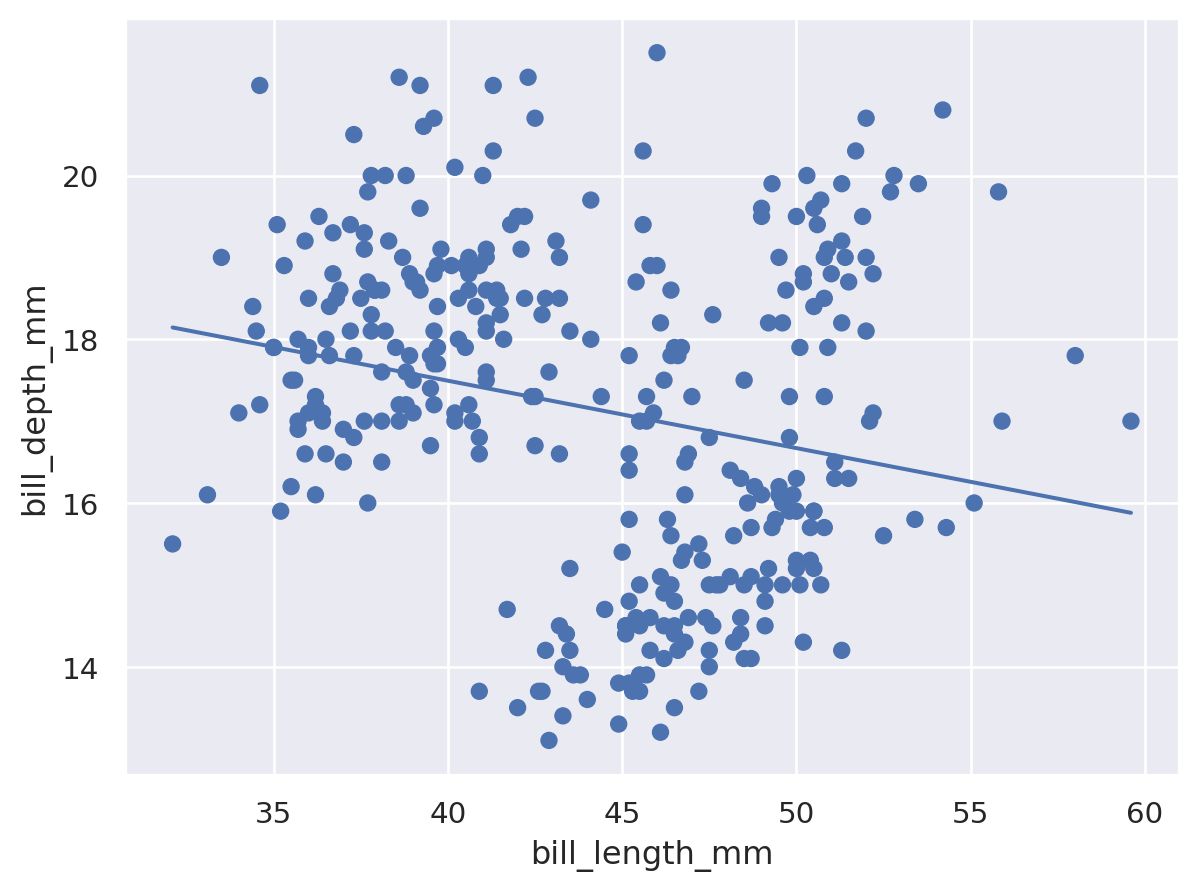

In [47]:
(
    so.Plot(data = penguins, x = "bill_length_mm", y = "bill_depth_mm")
    .add(so.Dot())
    .add(so.Line(), so.PolyFit(1))
)

El gráfico confirma la correlación negativa, pero notan algo raro? Tal vez hay algo que no estamos teniendo en cuenta?

.

.

.

.

.


.

.

.

.

.


.

.

.

.

.



Repetimos el gráfico coloreando los puntos según la especie.

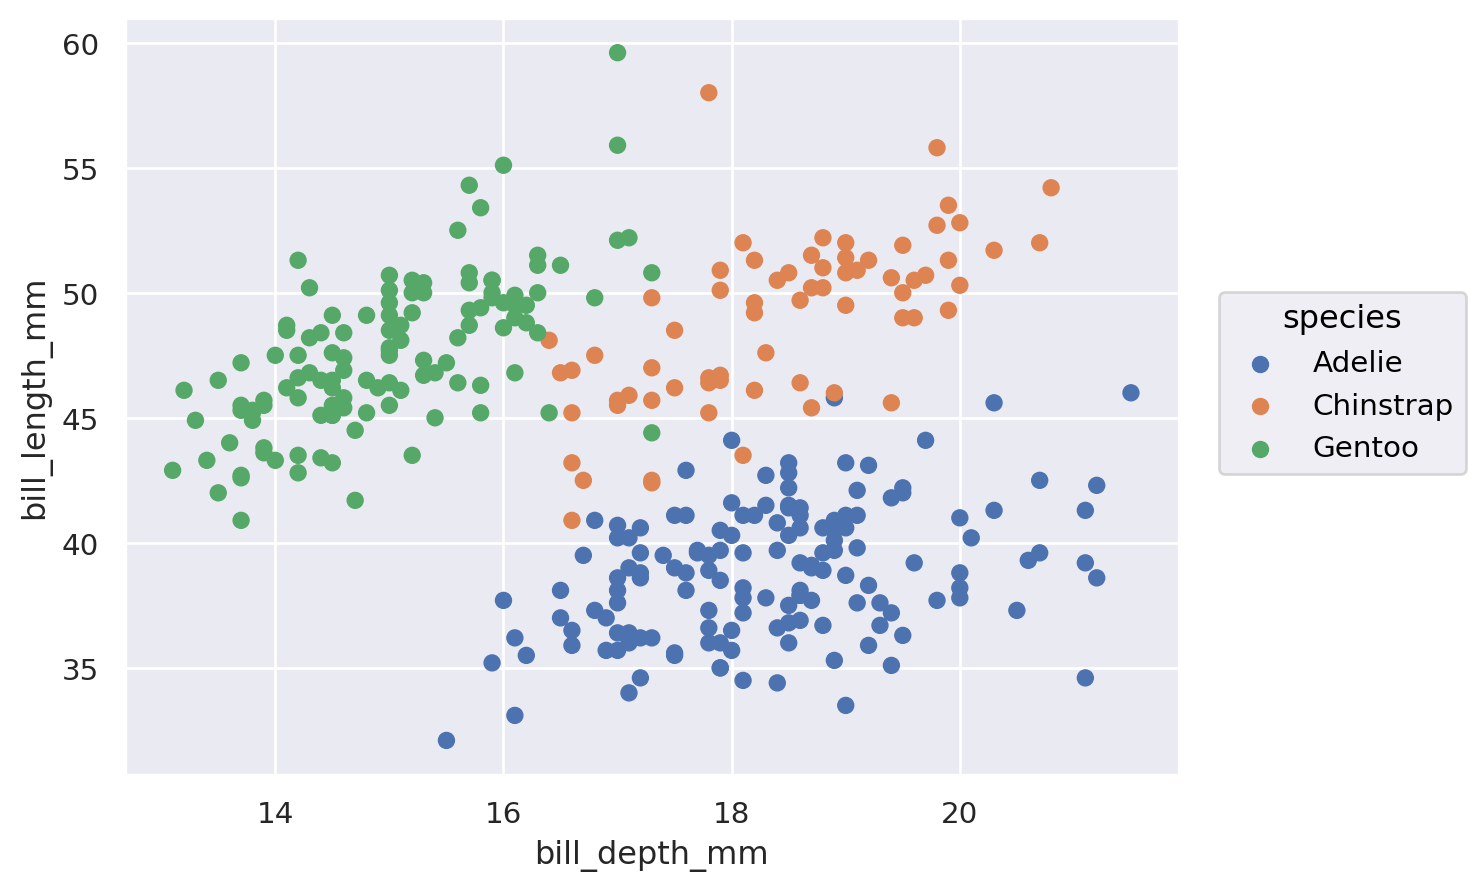

In [48]:
(
    so.Plot(data = penguins, x = "bill_depth_mm", y = "bill_length_mm", color = "species")
    .add(so.Dot())
)

En este gráfico por especie vemos dentro de cada especie puede haber correlación. Verificamos agregando los ajustes por especie.

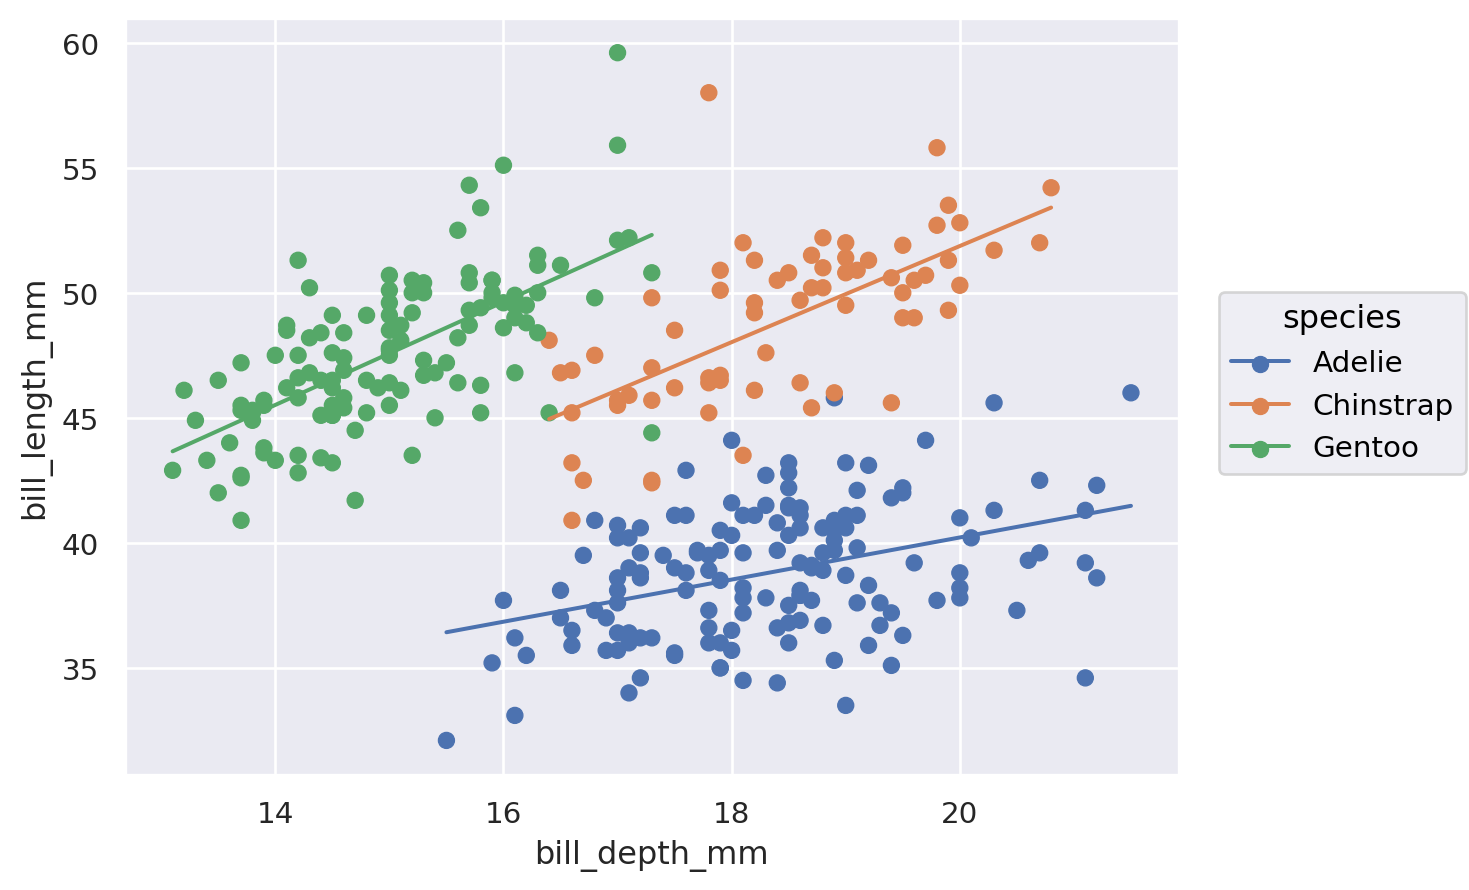

In [49]:
(
    so.Plot(data = penguins, x = "bill_depth_mm", y = "bill_length_mm", color = "species")
    .add(so.Dot())
    .add(so.Line(), so.PolyFit(1))
)

Ahora las rectas tienen pendiente positiva! Al considerar todas las especies al mismo tiempo, no podíamos ver esta correlación.

## La paradoja de Simpson
La paradoja de Simpson es un fenómeno estadístico en el cual una relación entre variables aparece, desaparece o se revierte al dividir a la población en subpoblaciones.

**Ejemplo.** Veamos otro ejemplo simulado.
Generamos dos poblaciones distribuidas aleatoriamente alrededor de dos centros.

In [50]:
from sklearn.datasets import make_blobs
centers = [[2, 2], [-2, -2]]
X, labels_true = make_blobs(
    n_samples=750, centers=centers, cluster_std=0.4, random_state=0)
x = X[:,0]
y = X[:,1]

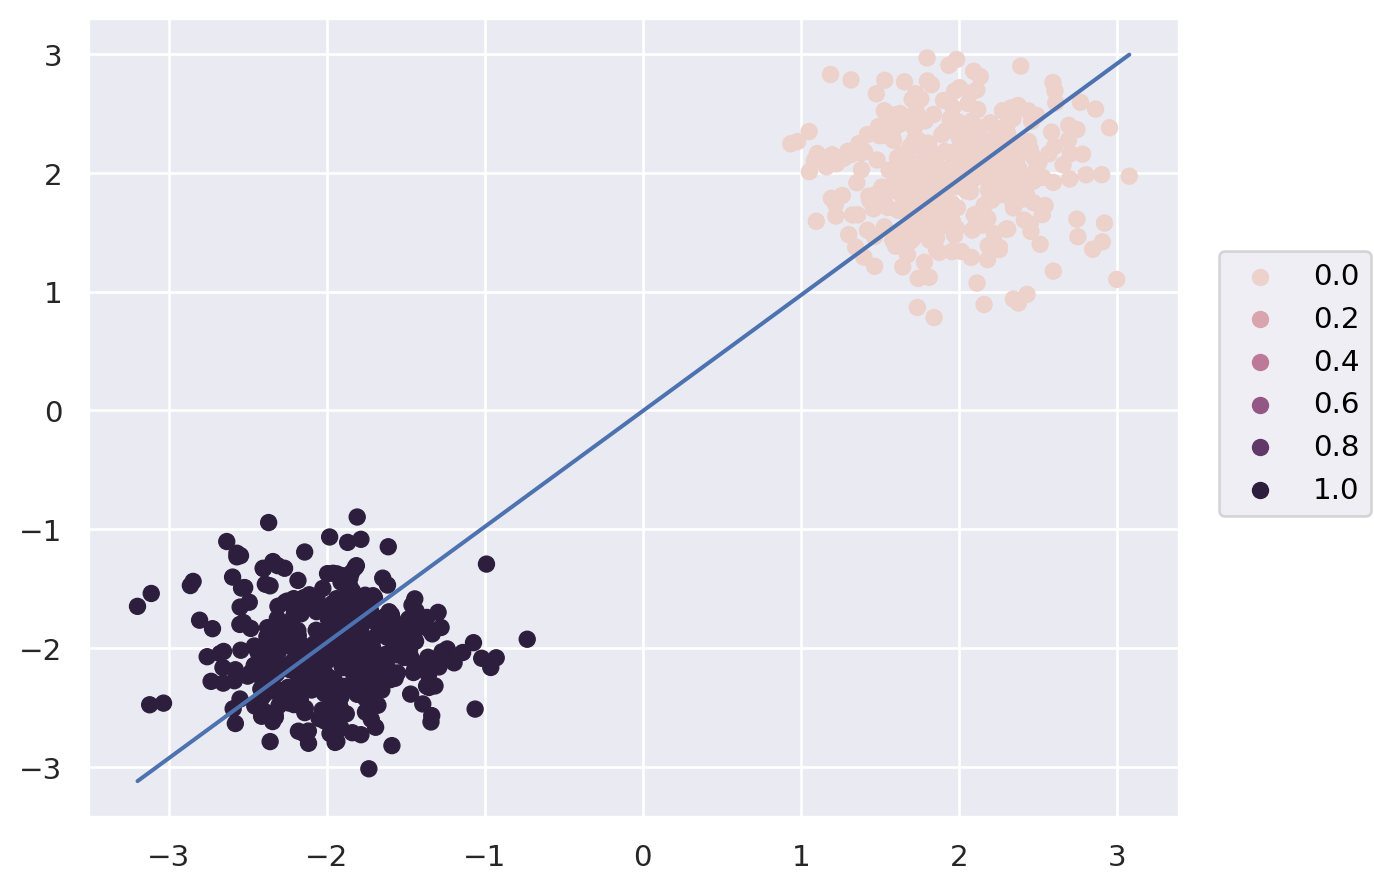

In [51]:
(
    so.Plot(x = x, y = y)
    .add(so.Dot(), color = labels_true)
    .add(so.Line(), so.PolyFit(1))
)

En este ejemplo, podríamos decir que hay correlación entre la variable $x$ y la variable $y$?

Calculemos el R^2...

In [52]:
modelo = linear_model.LinearRegression()    # Inicializamos un modelo de Regresion Lineal
modelo.fit(pd.DataFrame(x), y)   # Realiza

print("Coeficientes:", modelo.coef_)

# Medidas de bondad

y_pred = modelo.predict(pd.DataFrame(X[:,0]))

# Calculando el R^2
r2 = r2_score(X[:,1], y_pred)
print('R^2: ', r2)

Coeficientes: [0.97356812]
R^2:  0.9255602605070439


Los datos parecen altamente correlacionados. Pero si separamos por grupo...

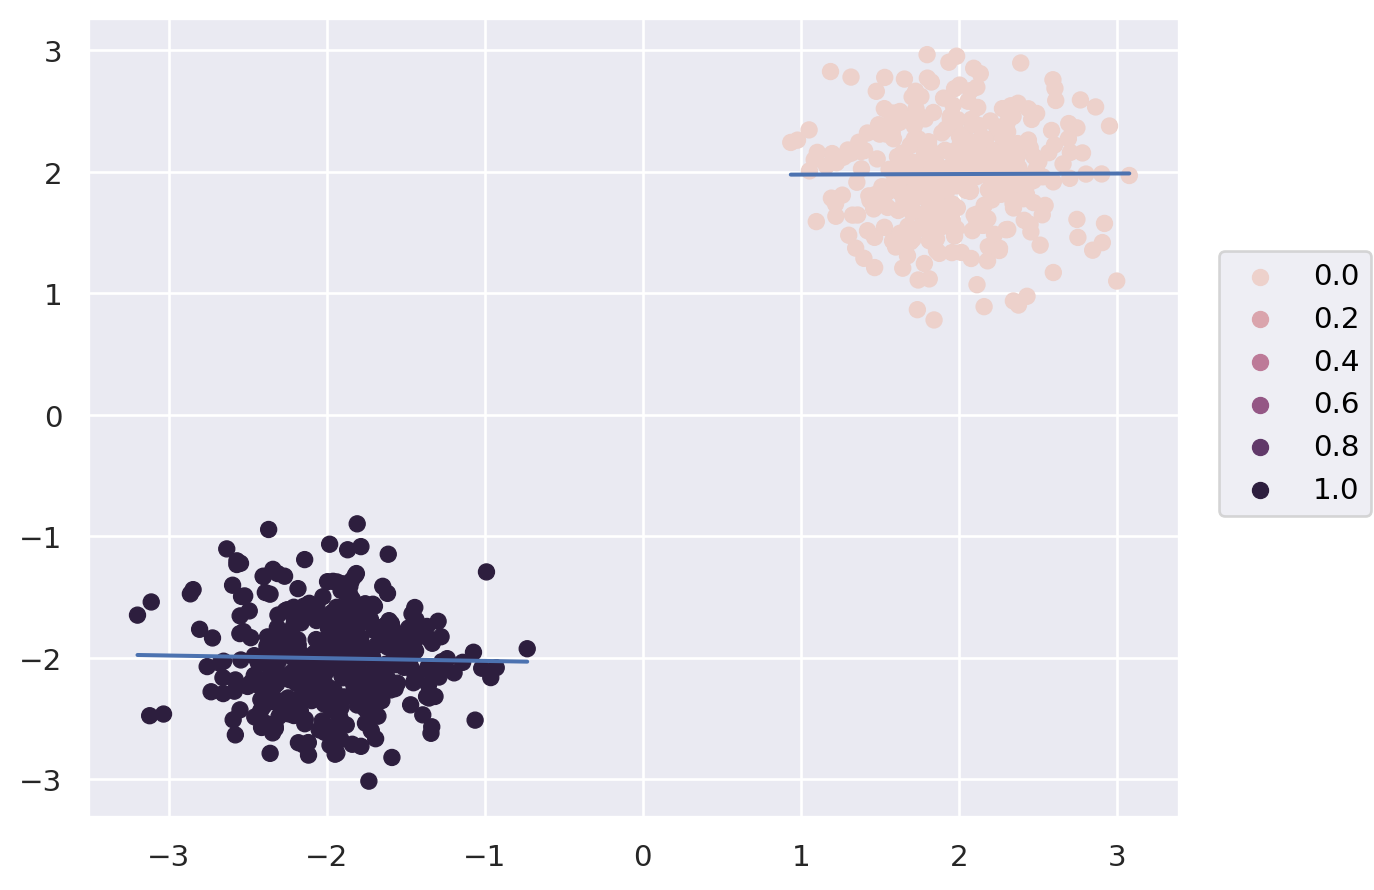

In [53]:
(
    so.Plot(x = x, y = y)
    .add(so.Dot(), color = labels_true)
    .add(so.Line(), so.PolyFit(1), group = labels_true)
)

Vemos en el gráfico que la pendiente ahora pasa a ser casi 0.

¿Cómo podemos construir nosotros estos modelos y calcular los coeficientes y el R^2?

Recordemos las operaciones que nos permite hacer Formulaic.

| Operador | Ejemplo          | Función                                                                                           |
|:---------|:-----------------|:---------------------------------------------------------------------------------------------------|
| ~        | y ~ x            | Separa la variable (y) respuesta a la izquierda, de el/los predictor/es a la derecha (x).       |
| +        | y ~ x + z        | Adiciona (suma) términos al modelo.                                                              |
| :        | y ~ x : z        | Interacción entre términos. y es lineal en x ⋅ z.                                                |
| *        | y ~ x * z        | Combina adición e interacción entre términos. y ~ x * z es equivalente a y ~ x + z + x : z       |

In [54]:
y, X = Formula("bill_length_mm ~ ???").get_model_matrix(penguins)
display(X)

FormulaSyntaxError: Unknown operator '?'.

bill_length_mm ⧛[1;31m~ ???[0m⧚

In [ ]:
modelo = linear_model.LinearRegression(fit_intercept = False)    # Inicializamos un modelo de Regresion Lineal sin intercept
modelo.fit(X, y)   # Realiza
print("Coeficientes:", modelo.coef_)

**Pregunta:** ¿Cuáles coeficientes nos indican las pendientes de las rectas?

In [ ]:
# Calculamos el R^2
y_pred = modelo.predict(X)

# Calculando el R^2
r2 = r2_score(y, y_pred)
print('R^2: ', r2)

In [ ]:
# Los últimos tres números son las pendientes de las rectas.
# Cómo podemos graficar este modelo?

y_pred = modelo.predict(X)

(
    so.Plot(data = penguins, x = "bill_depth_mm", y = "bill_length_mm", color = "species")
    .add(so.Dot())
    .add(so.Line(), ???)  # Otro milagro!! No le tenía ninguna fe a esto :)
)

**Ejercicio.** Realizar ahora un modelo donde todas las rectas tengan la misma pendiente y solo cambie el intercept según la especie.